In [1]:
import cv2, os, random
import numpy as np 
import pandas as pd 
import seaborn as sns
import networkx as nx
import load_networks as LN
import scipy.stats as stats
import matplotlib.pyplot as plt 

from tqdm import tqdm
from IPython.display import display

In [2]:
root_path = '/home/savvy/PROJECTS/PHD/DATA/' ### PATH of the downloaded folder from One Drive

protein_abundance = pd.read_csv(f'{root_path}protein_abundance/03_normalized_protein_abundance_after_gfp_filtering.csv', skiprows=1)
protein_abundance = protein_abundance.dropna(subset=['Mean molecules per cell'])

#### 1. Loading tables of all networks
print('Loading networks ...')
string_network =  LN.get_string_network(root_path)

# cellmap_network = LN.get_cellmap_network(root_path)

cellmap_network = pd.read_csv(f'{root_path}networks/preloaded_networks/cellmap_network.csv')

biogrid_network_2H = pd.read_csv(f'{root_path}networks/preloaded_networks/biogrid_2H_protein_abundances.csv')

biogrid_network_PCA = pd.read_csv(f'{root_path}networks/preloaded_networks/biogrid_pca_protein_abundances.csv')

intact_network = pd.read_csv(f'{root_path}networks/preloaded_networks/IntAct_PPI.csv')
intact_network['score'] = [ float(intact_network['Confidence.value.s.'][idx].split('intact-miscore:')[1]) for idx in intact_network.index ]
intact_network = intact_network[intact_network['score'] > 0.5]

# tarassov_network = pd.read_csv(f'{root_path}networks/preloaded_networks/tarassov_protein_abundances.csv')

#### 2. Generating proteins pairs for networkx
string_edges = set([ (x,y,z*100) for x, y, z in string_network[['protein1', 'protein2', 'experimental']].values.tolist()])
intact_edges = set([ (x,y,z*100) for x, y, z in intact_network[['InteractorA', 'InteractorB', 'score']].values.tolist()])
cellmap_edges = set([ (x,y, z*100) for x, y, z in cellmap_network[['protein1', 'protein2', 'pcc']].values.tolist()])
biogrid_2H_edges = set([ (x,y) for x, y in biogrid_network_2H[['protein1', 'protein2']].values.tolist()])
biogrid_PCA_edges = set([ (x,y) for x, y in biogrid_network_PCA[['protein1', 'protein2']].values.tolist()])
# tarassov_full_edges = set([ (x,y) for x, y in tarassov_network_full[['protein1', 'protein2']].values.tolist()])
# tarassov_hi_edges = set([ (x,y) for x, y in tarassov_network_hi[['protein1', 'protein2']].values.tolist()])

edges_dict = {
    'string':string_edges, 
    'cellMap':cellmap_edges,
    'intact':intact_edges,
    'biogrid_2H':biogrid_2H_edges, 
    'biogrid_PCA':biogrid_PCA_edges,
    # 'tarassov_full': tarassov_full_edges, 
    # 'tarassov_hi': tarassov_hi_edges, 
}

Loading networks ...


In [ ]:
cellmap_network

In [ ]:
cellmap_network.to_csv('/home/savvy/bin/safe/safe-data/networks/cellmap_network_ORFs.txt', index=False, sep='\t', header=False)

In [12]:
gene_loc = pd.read_csv('./data/mapping_table/S288C_genes.csv')

In [ ]:
##### Edge tables for Cytoscape
gene_mapping_dict = {} 

for key, value in gene_loc[['Locus', 'Gene']].values:
    gene_mapping_dict[key] = value
    
for network in [cellmap_network, string_network, biogrid_network_2H, biogrid_network_PCA]:
    network['Gene1'] = [ gene_mapping_dict[network['protein1'][idx]] if network['protein1'][idx] in gene_mapping_dict.keys() else network['protein1'][idx] for idx in network.index ]
    network['Gene2'] = [ gene_mapping_dict[network['protein2'][idx]] if network['protein2'][idx] in gene_mapping_dict.keys() else network['protein2'][idx] for idx in network.index ]

# cellmap_network.to_csv('./costanzo_network.csv', index=False)
# string_network.to_csv('./string_network.csv', index=False)
# biogrid_network_2H.to_csv('./biogrid_network_2H.csv', index=False)
# biogrid_network_PCA.to_csv('./biogrid_network_PCA.csv', index=False)

#### Example for loading one network

In [3]:
G_string = nx.Graph()
G_string.add_weighted_edges_from(edges_dict['string'])

G_intact = nx.Graph()
G_intact.add_weighted_edges_from(edges_dict['intact'])

G_cellMap = nx.Graph()
G_cellMap.add_weighted_edges_from(edges_dict['cellMap'])

G_2H = nx.Graph()
G_2H.add_edges_from(edges_dict['biogrid_2H'])

G_PCA = nx.Graph()
G_PCA.add_edges_from(edges_dict['biogrid_PCA'])

#### PPI information

In [13]:
def get_chr(x, gene_loc):
    try : 
        return gene_loc[gene_loc['Gene'] == x]['Chromosome_Name'].values[0].replace('CHR', '')
    except : 
        return np.nan

def get_locus(x, gene_loc):
    try : 
        return gene_loc[gene_loc['Gene'] == x]['Locus'].values[0]
    except:
        return np.nan

PPI_list = pd.read_csv('./data/mapping_table/PPI_reference_barcodes.csv')
PPI_list['PPI_bait'] =  [ PPI_list['PPI'][idx].split('_')[0] for idx in PPI_list.index ]
PPI_list['PPI_prey'] =  [ PPI_list['PPI'][idx].split('_')[1] for idx in PPI_list.index ]

PPI_list['CHR_bait'] = PPI_list['PPI_bait'].apply(get_chr, args=(gene_loc,))
PPI_list['CHR_prey'] = PPI_list['PPI_prey'].apply(get_chr, args=(gene_loc,))

PPI_list['Locus_bait'] = PPI_list['PPI_bait'].apply(get_locus, args=(gene_loc,))
PPI_list['Locus_prey'] = PPI_list['PPI_prey'].apply(get_locus, args=(gene_loc,))

In [ ]:
PPI_list

In [5]:
def vconcat_resize(img_list, interpolation=cv2.INTER_CUBIC):
    # take minimum width
    w_min = min(img.shape[1] for img in img_list)
      
    # resizing images
    im_list_resize = [cv2.resize(img, (w_min, int(img.shape[0] * w_min / img.shape[1])), interpolation = interpolation) for img in img_list]
    # return final image
    return cv2.vconcat(im_list_resize)
    
def hconcat_resize(img_list, interpolation=cv2.INTER_CUBIC):
    # take minimum hights
    h_min = min(img.shape[0] for img in img_list)
      
    # image resizing 
    im_list_resize = [cv2.resize(img, (int(img.shape[1] * h_min / img.shape[0]), h_min), interpolation = interpolation) 
                      for img in img_list]
      
    # return final image
    return cv2.hconcat(im_list_resize)

### Network visualization (V1)

In [ ]:
def display_network(G, PPI, MTX, DRUG, QTL_table, gene_loc):
    prey = PPI.split('_')[0]
    bait = PPI.split('_')[1]

    locus_prey = gene_loc[gene_loc['Gene'] == prey ]['Locus'].values[0]
    locus_bait = gene_loc[gene_loc['Gene'] == bait ]['Locus'].values[0]

    # display(QTL_table)
    
    QTLs = QTL_table[(QTL_table[f'{PPI}_{MTX}_{DRUG}'] == 1) & (QTL_table['location_type'] == 'true coding sequence') & (QTL_table['Chr'] != '15')].sort_values('-log_pval').drop_duplicates('systematic_id', keep='first')['systematic_id'].values.tolist()
    MTX_QTLs = QTL_table[(QTL_table[f'{PPI}_{MTX}_{DRUG}'] == 1) & (QTL_table['location_type'] == 'true coding sequence') & (QTL_table['Chr'] == '15')].sort_values('-log_pval').drop_duplicates('systematic_id', keep='first')['systematic_id'].values.tolist()
    noQTLs = QTL_table[(QTL_table[f'{PPI}_{MTX}_{DRUG}'] == 0) & (QTL_table['location_type'] == 'true coding sequence')].sort_values('-log_pval').drop_duplicates('systematic_id', keep='first')['systematic_id'].values.tolist()
    
    # print(QTLs)
    # print(MTX_QTLs)
    
    neighbors = [] 
    for p in G.nodes():
        if p in [locus_prey,locus_bait]: 
            neighbors.append(p)
            for n in G.neighbors(p) :
                neighbors.append(n)
        if p in MTX_QTLs :
            neighbors.append(p)
            for n in G.neighbors(p) :
                neighbors.append(n)
        if p in QTLs :
            neighbors.append(p)
            for n in G.neighbors(p) :
                neighbors.append(n)
            
    QTL_subG = G.subgraph(neighbors)

    color_map = [] 

    for node in QTL_subG :
        if node in [locus_prey,locus_bait]:
            color_map.append('green')
        elif node in MTX_QTLs : 
            color_map.append('orange')
        elif node in QTLs : 
            color_map.append('red')
        elif node in noQTLs : 
            color_map.append('powderblue')
        else: 
            color_map.append('black') 

    gene_mapping = {} 
    for locus in QTL_subG.nodes() : 
        try :
            gene_mapping[locus] = gene_loc[gene_loc['Locus'] == locus ]['Gene'].values[0]
        except :
            gene_mapping[locus] = locus

    QTL_subG = nx.relabel_nodes(QTL_subG, gene_mapping, copy=True)
    return QTL_subG, color_map 

In [ ]:
def save_plots(network, network_label):
    folder_path = './data/QTLs'
    for PPI in tqdm(['ERV25_ORM2']): 
        f, axes_i = plt.subplots(ncols=5, figsize=(100,25))
        g, axes_j = plt.subplots(ncols=5, figsize=(100,25))
        i = 0
        j = 0
        for DRUG in ['5.FC', 'Fluconazole', 'Metformin', 'Trifluoperazine', 'noDrug'] : 
            CHR_bait =  PPI_list[PPI_list['PPI'] == PPI]['CHR_bait'].values[0] 
            CHR_prey = PPI_list[PPI_list['PPI'] == PPI]['CHR_prey'].values[0]

            MTX = pd.read_csv(os.path.join(folder_path,f'{PPI}_MTX_{DRUG}_avg_logratio_Fitness_substract_ref.csv'))
            MTX = MTX.rename(columns={f'{PPI}_MTX_{DRUG}_avg_logratio_Fitness_substract_ref.GLM':'p-value'})
            MTX['SNP_ID'] = [ f'CHR{MTX["Chr"][idx]}_{MTX["Pos"][idx]}' for idx in MTX.index ]
            noMTX = pd.read_csv(os.path.join(folder_path,f'{PPI}_noMTX_{DRUG}_avg_logratio_Fitness_substract_ref.csv'))
            noMTX = noMTX.rename(columns={f'{PPI}_noMTX_{DRUG}_avg_logratio_Fitness_substract_ref.GLM':'p-value'})
            noMTX['SNP_ID'] = [ f'CHR{noMTX["Chr"][idx]}_{noMTX["Pos"][idx]}' for idx in noMTX.index ]
            
            MTX['-log_pval'] = -np.log10(MTX['p-value'])
            MTX[f'{PPI}_MTX_{DRUG}'] = MTX['-log_pval'] >= 3
            MTX[f'{PPI}_MTX_{DRUG}'] = MTX[f'{PPI}_MTX_{DRUG}'].astype(int)
            f_graph, f_color_map = display_network(network, PPI, 'MTX', DRUG, MTX, gene_loc)
            try:
                nx.draw(f_graph, with_labels=True, node_color=f_color_map, pos=nx.nx_agraph.graphviz_layout(f_graph, prog="fdp"), font_size=10, node_size=[v * 10 for n, v in nx.degree(f_graph)], ax=axes_i[i])
                axes_i[i].set_title(f'{PPI} + MTX under {DRUG}', fontsize=16)
            except :
                axes_i[i].set_title(f'{PPI} + MTX under {DRUG}', fontsize=16)
            i += 1
            
            noMTX['-log_pval'] = -np.log10(noMTX['p-value'])
            noMTX[f'{PPI}_noMTX_{DRUG}'] = noMTX['-log_pval'] >= 3
            noMTX[f'{PPI}_noMTX_{DRUG}'] = noMTX[f'{PPI}_noMTX_{DRUG}'].astype(int)
            g_graph, g_color_map = display_network(network, PPI, 'noMTX', DRUG, noMTX, gene_loc)
            try : 
                nx.draw(g_graph, with_labels=True, node_color=g_color_map, pos=nx.nx_agraph.graphviz_layout(g_graph, prog="fdp"), font_size=10, node_size=[v * 10 for n, v in nx.degree(g_graph)], ax=axes_j[j])
                axes_j[j].set_title(f'{PPI} + noMTX under {DRUG}', fontsize=16)
            except :
                axes_j[j].set_title(f'{PPI} + noMTX under {DRUG}', fontsize=16)
            j += 1
        break
    
        
        # f.savefig(f'./figures/{network_label}/MTX.png', dpi=150)
        # g.savefig(f'./figures/{network_label}/noMTX.png', dpi=150)

        # img1 = cv2.imread(f'./figures/{network_label}/MTX.png')
        # img2 = cv2.imread(f'./figures/{network_label}/noMTX.png')
        # img_v_resize = vconcat_resize([img1, img2])
        # cv2.imwrite(f'./figures/{network_label}/{PPI}_{network_label}.png', img_v_resize)
        # plt.close()


In [ ]:
save_plots(G_PCA, 'Biogrid_PCA')

In [ ]:
save_plots(G_2H, 'Biogrid_2H')

In [ ]:
save_plots(G_string, 'String')

In [ ]:
save_plots(G_cellMap, 'CellMap')

### Network visualization (V2)

In [ ]:
def display_network_v2(G, PPI, MTX, DRUG, QTL_table, gene_loc):
    prey = PPI.split('_')[0]
    bait = PPI.split('_')[1]

    locus_prey = gene_loc[gene_loc['Gene'] == prey ]['Locus'].values[0]
    locus_bait = gene_loc[gene_loc['Gene'] == bait ]['Locus'].values[0]

    # display(QTL_table)
    
    QTLs = QTL_table[(QTL_table[f'{PPI}_{MTX}_{DRUG}'].abs() == 1) & (QTL_table['location_type'] == 'true coding sequence') & (QTL_table['Chr'] != '15')].sort_values('-log_pval').drop_duplicates('systematic_id', keep='first')['systematic_id'].values.tolist()
    MTX_QTLs = QTL_table[(QTL_table[f'{PPI}_{MTX}_{DRUG}'].abs() == 1) & (QTL_table['location_type'] == 'true coding sequence') & (QTL_table['Chr'] == '15')].sort_values('-log_pval').drop_duplicates('systematic_id', keep='first')['systematic_id'].values.tolist()
    noQTLs = QTL_table[(QTL_table[f'{PPI}_{MTX}_{DRUG}'] == 0) & (QTL_table['location_type'] == 'true coding sequence')].sort_values('-log_pval').drop_duplicates('systematic_id', keep='first')['systematic_id'].values.tolist()
    
    # print(QTLs)
    # print(MTX_QTLs)
    
    neighbors = [] 
    for p in G.nodes():
        if p in [locus_prey,locus_bait]: 
            neighbors.append(p)
            for n in G.neighbors(p) :
                neighbors.append(n)
                for i in range(0,1+1):
                    neighbors += list(nx.descendants_at_distance(G,p,i))
        if p in MTX_QTLs :
            neighbors.append(p)
            for n in G.neighbors(p) :
                neighbors.append(n)
                for i in range(0,1+1):
                    neighbors += list(nx.descendants_at_distance(G,p,i))
        if p in QTLs :
            neighbors.append(p)
            for n in G.neighbors(p) :
                neighbors.append(n)
                for i in range(0,1+1):
                    neighbors += list(nx.descendants_at_distance(G,p,i))
            
    QTL_subG = G.subgraph(neighbors)

    attrs = {}
    for node in QTL_subG :
        attrs[node] = {}
        attrs[node]['degree'] = QTL_subG.degree(node)
        try: 
            attrs[node]['label'] = gene_loc[gene_loc['Locus'] == node ]['Gene'].values[0]
        except: 
            attrs[node]['label'] = node
        effect_size_list = QTL_table[QTL_table['systematic_id'] == node ]['Effect'].values
        if len(effect_size_list) != 0 :
            effect_size = np.mean(effect_size_list)
            effect_size = effect_size * 100
        else :
            effect_size = 0
        
        if node in [locus_prey, locus_bait]:
            attrs[node]['color'] = 'red'
            if effect_size == np.nan : 
                if effect_size > 0 : 
                    attrs[node]['QTL'] = 1
                elif effect_size < 0 :
                    attrs[node]['QTL'] = -1
            else :
                 attrs[node]['QTL'] = 0
        elif (node in MTX_QTLs) or (node in QTLs) :
            if effect_size > 0 : 
                attrs[node]['color'] = 'green'
                attrs[node]['QTL'] = 1
            elif effect_size < 0 : 
                attrs[node]['color'] = 'purple' 
                attrs[node]['QTL'] = -1
        elif node in noQTLs : 
            attrs[node]['color'] ='powderblue'
            attrs[node]['QTL'] = 0
        else: 
            attrs[node]['color'] ='grey'
            effect_size = 0.01
            attrs[node]['QTL'] = 0
            
        attrs[node]['effect_size'] = abs(effect_size)
        
    nx.set_node_attributes(QTL_subG, attrs)

    return QTL_subG, attrs, locus_prey, locus_bait, QTLs, MTX_QTLs

## Network visualization (V3)

In [26]:
def display_network_v3(G, PPI, MTX, DRUG, QTL_table, gene_loc):
    prey = PPI.split('_')[0]
    bait = PPI.split('_')[1]

    locus_prey = gene_loc[gene_loc['Gene'] == prey ]['Locus'].values[0]
    locus_bait = gene_loc[gene_loc['Gene'] == bait ]['Locus'].values[0]

    # display(QTL_table)
    
    QTLs = QTL_table[(QTL_table['snps_class_up'] == 'ORF') & (QTL_table['-log_pval'] > 4)].sort_values('-log_pval').drop_duplicates('GENE', keep='first')['locus_id'].values.tolist()
    noQTLs = QTL_table[(QTL_table['snps_class_up'] == 'ORF') & (QTL_table['-log_pval'] <= 4)].sort_values('-log_pval').drop_duplicates('GENE', keep='first')['locus_id'].values.tolist()

    neighbors = [] 
    for p in G.nodes():
        if p in [locus_prey,locus_bait]: 
            neighbors.append(p)
            for n in G.neighbors(p) :
                neighbors.append(n)
                for i in range(0,1+2):
                    neighbors += list(nx.descendants_at_distance(G,p,i))
        if p in QTLs :
            neighbors.append(p)
            for n in G.neighbors(p) :
                neighbors.append(n)
                for i in range(0,1+2):
                    neighbors += list(nx.descendants_at_distance(G,p,i))
    

    QTL_subG = G.subgraph(neighbors)

    attrs = {}
    for node in QTL_subG :
        attrs[node] = {}
        attrs[node]['degree'] = QTL_subG.degree(node)
        try: 
            attrs[node]['label'] = gene_loc[gene_loc['Locus'] == node ]['Gene'].values[0]    
        except: 
            attrs[node]['label'] = node
        
        lod = 10
        if node in [locus_prey, locus_bait]:
            attrs[node]['color'] = 'red'
            lod_list = QTL_table[QTL_table['locus_id'] == node ]['-log_pval'].values
            if len(lod_list) != 0 :
                lod = np.max(lod_list)
                lod = lod * 10
            else : 
                lod = 4 * 10
        elif (node in QTLs) :
            attrs[node]['color'] = 'blue'
            lod_list = QTL_table[QTL_table['locus_id'] == node ]['-log_pval'].values
            if len(lod_list) != 0 :
                lod = np.max(lod_list)
                lod = lod * 10
        elif node in noQTLs : 
            attrs[node]['color'] ='black'
        else: 
            attrs[node]['color'] ='black'
            lod = 10
            
        attrs[node]['lod'] = lod
        
    nx.set_node_attributes(QTL_subG, attrs)

    return QTL_subG, attrs, locus_prey, locus_bait, QTLs

In [7]:
def get_network(G, PPI, MTX, DRUG, QTL_table, gene_loc):
    prey = PPI.split('_')[0]
    bait = PPI.split('_')[1]

    locus_prey = gene_loc[gene_loc['Gene'] == prey ]['Locus'].values[0]
    locus_bait = gene_loc[gene_loc['Gene'] == bait ]['Locus'].values[0]

    # display(QTL_table)
    
    QTLs = QTL_table[(QTL_table['snps_class_up'] == 'ORF') & (QTL_table['-log_pval'] > 4)].sort_values('-log_pval').drop_duplicates('GENE', keep='first')['locus_id'].values.tolist()
    noQTLs = QTL_table[(QTL_table['snps_class_up'] == 'ORF') & (QTL_table['-log_pval'] <= 4)].sort_values('-log_pval').drop_duplicates('GENE', keep='first')['locus_id'].values.tolist()

    neighbors = [] 
    for p in G.nodes():
        if p in [locus_prey,locus_bait]: 
            neighbors.append(p)
            for n in G.neighbors(p) :
                neighbors.append(n)
                for i in range(0,1+1):
                    neighbors += list(nx.descendants_at_distance(G,p,i))
        if p in QTLs :
            neighbors.append(p)
            for n in G.neighbors(p) :
                neighbors.append(n)
                for i in range(0,1+1):
                    neighbors += list(nx.descendants_at_distance(G,p,i))
    

    QTL_subG = G.subgraph(neighbors)

    attrs = {}
    for node in QTL_subG :
        attrs[node] = {}
        attrs[node]['degree'] = QTL_subG.degree(node)
        try: 
            attrs[node]['label'] = gene_loc[gene_loc['Locus'] == node ]['Gene'].values[0]    
        except: 
            attrs[node]['label'] = node
        
        lod = 10
        if node in [locus_prey, locus_bait]:
            attrs[node]['color'] = 'red'
            lod_list = QTL_table[QTL_table['locus_id'] == node ]['-log_pval'].values
            if len(lod_list) != 0 :
                lod = np.max(lod_list)
                lod = lod * 10
            else : 
                lod = 4 * 10
        elif (node in QTLs) :
            attrs[node]['color'] = 'blue'
            lod_list = QTL_table[QTL_table['locus_id'] == node ]['-log_pval'].values
            if len(lod_list) != 0 :
                lod = np.max(lod_list)
                lod = lod * 10
        elif node in noQTLs : 
            attrs[node]['color'] ='black'
        else: 
            attrs[node]['color'] ='black'
            lod = 10
            
        attrs[node]['lod'] = lod
        
    nx.set_node_attributes(QTL_subG, attrs)
    QTLs.append(locus_prey)
    QTLs.append(locus_bait)
    return QTL_subG, attrs, QTLs, noQTLs

In [21]:
def set_correlation_score(idx, table):
    z_score = table['-log_pval'][idx]
    effect = table['EFFECTSIZE'][idx]
    if z_score >= 4 :
        if effect > 0 :
            return 1 
        elif effect < 0 :
            return -1 
    else :
        return 0

In [ ]:
### Choose the best PPI to display

In [10]:
#### You need to remove the MTX-specific piQTLs before performing the other steps
MTX_QTLs = pd.read_csv('../piQTL_version_0/results/05_piQTL_tables/MTX_specific_QTLs_with_genome_annotations.csv')
MTX_QTLs['SNP_ID'] = [ f'CHR{MTX_QTLs["Chr"][idx]}_{MTX_QTLs["SNP"][idx]}' for idx in MTX_QTLs.index ]
MTX_piQTLs = list(MTX_QTLs['SNP_ID'])
MTX_piQTLs.append('CHR15_10455')
MTX_piQTLs.append('CHR15_10456')
MTX_piQTLs.append('CHR15_10468')

In [17]:
piQTL_stats = [] 

folder_path = '../piQTL_version_0/data/piQTLs/piQTL_without_MTX/'
for PPI in tqdm(PPI_list['PPI']): 
    for DRUG in ['Fluconazole'] : 
        CHR_bait =  PPI_list[PPI_list['PPI'] == PPI]['CHR_bait'].values[0] 
        CHR_prey = PPI_list[PPI_list['PPI'] == PPI]['CHR_prey'].values[0]

        MTX = pd.read_csv(os.path.join(folder_path,f'{PPI}_MTX_{DRUG}_avg_logratio_Fitness_minus_ref.csv'))
        MTX = MTX[~MTX['SNP_ID'].isin(MTX_piQTLs)]
        MTX['-log_pval'] = -np.log10(MTX['P'])

        piQTLs_ORF = MTX[(MTX['snps_class_up'] == 'ORF') & (MTX['-log_pval'] >= 4)].sort_values('-log_pval').drop_duplicates('GENE', keep='first')
        piQTLs_in_network = [ piQTL for piQTL in set(piQTLs_ORF['locus_id']) if piQTL in G_PCA.nodes() ]
        
        piQTL_stats.append([PPI, len(piQTLs_in_network)])
        

100%|██████████| 62/62 [00:09<00:00,  6.81it/s]


In [288]:
piQTLs_stats = pd.DataFrame(piQTL_stats, columns=['PPI', 'piQTLs']).sort_values('piQTLs', ascending=False)
piQTLs_stats[piQTLs_stats['piQTLs'] >= 2]

,PPI,piQTLs
17,ERG11_PIS1,9
46,ERG11_ORM2,8
32,ERG11_MID2,7
36,SRO9_GIS2,6
7,ERV25_ORM2,6
15,ERV25_ERG5,5
14,SSH1_ERG11,5
2,ERG11_HYR1,4
44,HNM1_RBD2,4
0,GTR1_SLM4,3


#### One example (PCA)

100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


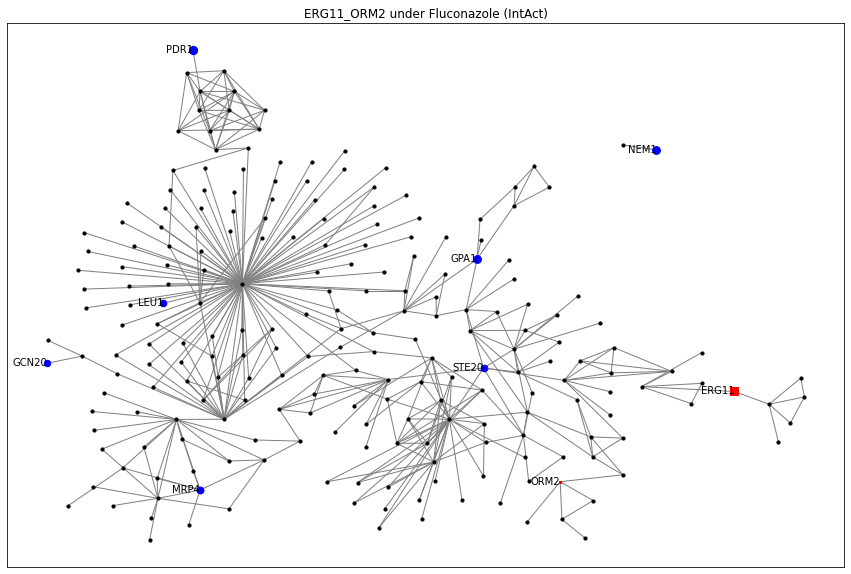

In [27]:
folder_path = '../piQTL_version_0/data/piQTLs/piQTL_without_MTX/'
for PPI in tqdm(['ERG11_ORM2']): 
    for DRUG in ['Fluconazole'] : 
        CHR_bait =  PPI_list[PPI_list['PPI'] == PPI]['CHR_bait'].values[0] 
        CHR_prey = PPI_list[PPI_list['PPI'] == PPI]['CHR_prey'].values[0]

        MTX = pd.read_csv(os.path.join(folder_path,f'{PPI}_MTX_{DRUG}_avg_logratio_Fitness_minus_ref.csv'))
        MTX['SNP_ID'] = [ f'CHR{MTX["CHR"][idx]}_{MTX["SNP"][idx]}' for idx in MTX.index ]
        MTX['-log_pval'] = -np.log10(MTX['P'])
        MTX[f'{PPI}_MTX_{DRUG}'] = [ set_correlation_score(idx, MTX) for idx in MTX.index ]
        f_graph, attrs, PPI_left, PPI_right, piQTLs  = display_network_v3(G_intact, PPI, 'MTX', DRUG, MTX, gene_loc)
        

layout = nx.nx_agraph.graphviz_layout(f_graph, prog="fdp")

f = plt.figure(figsize=(15,10))

for node in f_graph.nodes() :
    if (node == PPI_left) or (node == PPI_right):
        nx.draw_networkx_nodes(f_graph, pos=layout, nodelist=[node], node_color=attrs[node]['color'], node_size=attrs[node]['lod'], label=attrs[node]['label'], node_shape='s')     
    elif node in piQTLs:
        nx.draw_networkx_nodes(f_graph, pos=layout, nodelist=[node], node_color=attrs[node]['color'], node_size=attrs[node]['lod'], label=attrs[node]['label'])
    else :
        nx.draw_networkx_nodes(f_graph, pos=layout, nodelist=[node], node_color=attrs[node]['color'], node_size=attrs[node]['lod'])
   
for edge in f_graph.edges(data="weight"):
    if (PPI_left in edge) and (PPI_right in edge):
        nx.draw_networkx_edges(f_graph, pos=layout, edgelist=[edge], edge_color='red')
    else : 
        nx.draw_networkx_edges(f_graph, pos=layout, edgelist=[edge], edge_color='grey')

nx.draw_networkx_labels(f_graph, pos=layout, font_size=10, horizontalalignment='right', labels={n:attrs[n]['label'] for n in attrs.keys() if (n in [PPI_left, PPI_right]) or (n in piQTLs)})

plt.title(f'{PPI} under Fluconazole (IntAct)')
plt.show()

f.savefig(f'./{PPI}_Fluconazole_IntAct.eps', dpi=300)

In [38]:
len(MTX[MTX['locus_id'].isin(piQTLs)].drop_duplicates(subset='GENE'))

18

['YGL008C',
 'YFR009W',
 'YHL007C',
 'YHR017W',
 'YHL004W',
 'YGL009C',
 'YHL015W-A',
 'YGL017W',
 'YHR015W',
 'YGL013C',
 'YGL016W',
 'YHR005C',
 'YGL015C',
 'YHR004C',
 'YGL014W',
 'YHR006W',
 'YHR007C',
 'YHR009C']

100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


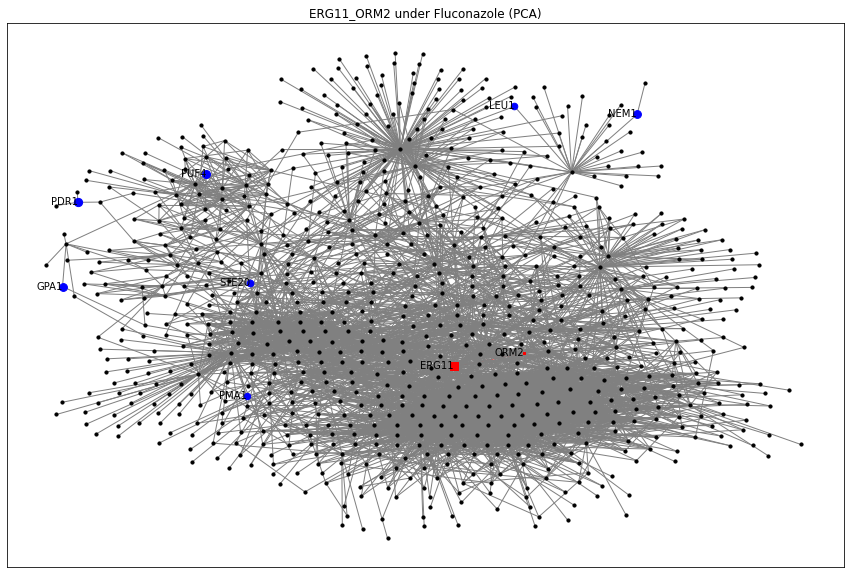

In [39]:
folder_path = '../piQTL_version_0/data/piQTLs/piQTL_without_MTX/'
for PPI in tqdm(['ERG11_ORM2']): 
    for DRUG in ['Fluconazole'] : 
        CHR_bait =  PPI_list[PPI_list['PPI'] == PPI]['CHR_bait'].values[0] 
        CHR_prey = PPI_list[PPI_list['PPI'] == PPI]['CHR_prey'].values[0]

        MTX = pd.read_csv(os.path.join(folder_path,f'{PPI}_MTX_{DRUG}_avg_logratio_Fitness_minus_ref.csv'))
        MTX['SNP_ID'] = [ f'CHR{MTX["CHR"][idx]}_{MTX["SNP"][idx]}' for idx in MTX.index ]
        MTX['-log_pval'] = -np.log10(MTX['P'])
        MTX[f'{PPI}_MTX_{DRUG}'] = [ set_correlation_score(idx, MTX) for idx in MTX.index ]
        f_graph, attrs, PPI_left, PPI_right, piQTLs  = display_network_v3(G_PCA, PPI, 'MTX', DRUG, MTX, gene_loc)
        

layout = nx.nx_agraph.graphviz_layout(f_graph, prog="fdp")

f = plt.figure(figsize=(15,10))

for node in f_graph.nodes() :
    if (node == PPI_left) or (node == PPI_right):
        nx.draw_networkx_nodes(f_graph, pos=layout, nodelist=[node], node_color=attrs[node]['color'], node_size=attrs[node]['lod'], label=attrs[node]['label'], node_shape='s')     
    elif node in piQTLs:
        nx.draw_networkx_nodes(f_graph, pos=layout, nodelist=[node], node_color=attrs[node]['color'], node_size=attrs[node]['lod'], label=attrs[node]['label'])
    else :
        nx.draw_networkx_nodes(f_graph, pos=layout, nodelist=[node], node_color=attrs[node]['color'], node_size=attrs[node]['lod'])
   
for edge in f_graph.edges(data="weight"):
    if (PPI_left in edge) and (PPI_right in edge):
        nx.draw_networkx_edges(f_graph, pos=layout, edgelist=[edge], edge_color='red')
    else : 
        nx.draw_networkx_edges(f_graph, pos=layout, edgelist=[edge], edge_color='grey')

nx.draw_networkx_labels(f_graph, pos=layout, font_size=10, horizontalalignment='right', labels={n:attrs[n]['label'] for n in attrs.keys() if (n in [PPI_left, PPI_right]) or (n in piQTLs)})

plt.title(f'{PPI} under Fluconazole (PCA)')
plt.show()

f.savefig(f'./{PPI}_Fluconazole_PCA.eps', dpi=300)

100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


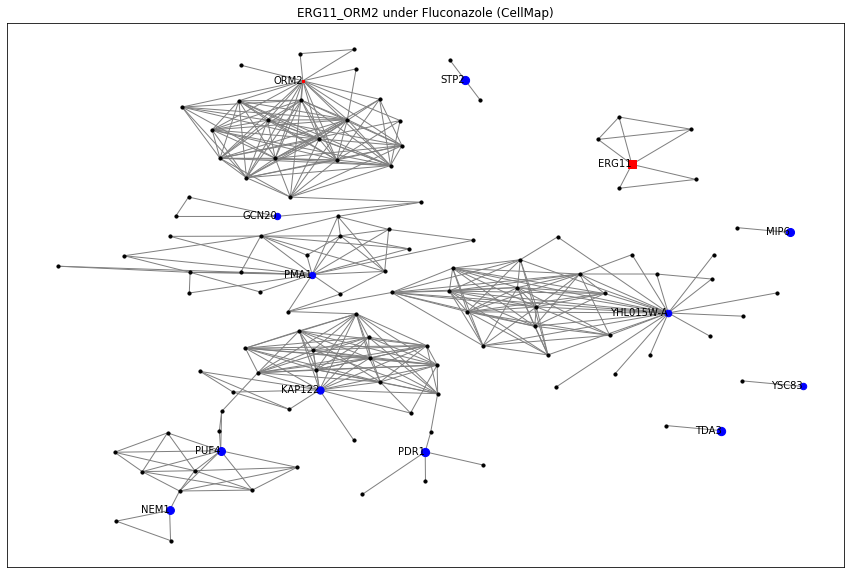

In [25]:
folder_path = '../piQTL_version_0/data/piQTLs/piQTL_without_MTX/'
for PPI in tqdm(['ERG11_ORM2']): 
    for DRUG in ['Fluconazole'] : 
        CHR_bait =  PPI_list[PPI_list['PPI'] == PPI]['CHR_bait'].values[0] 
        CHR_prey = PPI_list[PPI_list['PPI'] == PPI]['CHR_prey'].values[0]

        MTX = pd.read_csv(os.path.join(folder_path,f'{PPI}_MTX_{DRUG}_avg_logratio_Fitness_minus_ref.csv'))
        MTX['SNP_ID'] = [ f'CHR{MTX["CHR"][idx]}_{MTX["SNP"][idx]}' for idx in MTX.index ]
        MTX['-log_pval'] = -np.log10(MTX['P'])
        MTX[f'{PPI}_MTX_{DRUG}'] = [ set_correlation_score(idx, MTX) for idx in MTX.index ]
        f_graph, attrs, PPI_left, PPI_right, piQTLs  = display_network_v3(G_cellMap, PPI, 'MTX', DRUG, MTX, gene_loc)
        

layout = nx.nx_agraph.graphviz_layout(f_graph, prog="fdp")

f = plt.figure(figsize=(15,10))

for node in f_graph.nodes() :
    if (node == PPI_left) or (node == PPI_right):
        nx.draw_networkx_nodes(f_graph, pos=layout, nodelist=[node], node_color=attrs[node]['color'], node_size=attrs[node]['lod'], label=attrs[node]['label'], node_shape='s')     
    elif node in piQTLs:
        nx.draw_networkx_nodes(f_graph, pos=layout, nodelist=[node], node_color=attrs[node]['color'], node_size=attrs[node]['lod'], label=attrs[node]['label'])
    else :
        nx.draw_networkx_nodes(f_graph, pos=layout, nodelist=[node], node_color=attrs[node]['color'], node_size=attrs[node]['lod'])
   
for edge in f_graph.edges(data="weight"):
    if (PPI_left in edge) and (PPI_right in edge):
        nx.draw_networkx_edges(f_graph, pos=layout, edgelist=[edge], edge_color='red')
    else : 
        nx.draw_networkx_edges(f_graph, pos=layout, edgelist=[edge], edge_color='grey')

nx.draw_networkx_labels(f_graph, pos=layout, font_size=10, horizontalalignment='right', labels={n:attrs[n]['label'] for n in attrs.keys() if (n in [PPI_left, PPI_right]) or (n in piQTLs)})

plt.title(f'{PPI} under Fluconazole (CellMap)')
plt.show()

f.savefig(f'./{PPI}_Fluconazole_CellMap.eps', dpi=300)

In [ ]:
folder_path = '../piQTL/data/QTL'
for PPI in tqdm(['ERG11_ORM2']): 
    for DRUG in ['Fluconazole'] : 
        CHR_bait =  PPI_list[PPI_list['PPI'] == PPI]['CHR_bait'].values[0] 
        CHR_prey = PPI_list[PPI_list['PPI'] == PPI]['CHR_prey'].values[0]

        MTX = pd.read_csv(os.path.join(folder_path,f'{PPI}_MTX_{DRUG}_avg_logratio_Fitness_minus_ref.csv'))
        MTX['SNP_ID'] = [ f'CHR{MTX["CHR"][idx]}_{MTX["SNP"][idx]}' for idx in MTX.index ]
        MTX['-log_pval'] = -np.log10(MTX['P'])
        MTX[f'{PPI}_MTX_{DRUG}'] = [ set_correlation_score(idx, MTX) for idx in MTX.index ]
        f_graph, attrs, PPI_left, PPI_right, piQTLs  = display_network_v3(G_intact, PPI, 'MTX', DRUG, MTX, gene_loc)
        

layout = nx.nx_agraph.graphviz_layout(f_graph, prog="fdp")

f = plt.figure(figsize=(15,10))

for node in f_graph.nodes() :
    if (node == PPI_left) or (node == PPI_right):
        nx.draw_networkx_nodes(f_graph, pos=layout, nodelist=[node], node_color=attrs[node]['color'], node_size=attrs[node]['lod'], label=attrs[node]['label'], node_shape='s')     
    elif node in piQTLs:
        nx.draw_networkx_nodes(f_graph, pos=layout, nodelist=[node], node_color=attrs[node]['color'], node_size=attrs[node]['lod'], label=attrs[node]['label'])
    else :
        nx.draw_networkx_nodes(f_graph, pos=layout, nodelist=[node], node_color=attrs[node]['color'], node_size=attrs[node]['lod'])
   
for edge in f_graph.edges(data="weight"):
    if (PPI_left in edge) and (PPI_right in edge):
        nx.draw_networkx_edges(f_graph, pos=layout, edgelist=[edge], edge_color='red')
    else : 
        nx.draw_networkx_edges(f_graph, pos=layout, edgelist=[edge], edge_color='grey')

nx.draw_networkx_labels(f_graph, pos=layout, font_size=10, horizontalalignment='right', labels={n:attrs[n]['label'] for n in attrs.keys() if (n in [PPI_left, PPI_right]) or (n in piQTLs)})

plt.title(f'{PPI} under Fluconazole (IntAct)')
plt.show()

f.savefig(f'./{PPI}_Fluconazole_IntAct.eps', dpi=300)

In [ ]:
folder_path = '../piQTL/data/QTL'
for PPI in tqdm(['ERG11_ORM2']): 
    for DRUG in ['Fluconazole'] : 
        CHR_bait =  PPI_list[PPI_list['PPI'] == PPI]['CHR_bait'].values[0] 
        CHR_prey = PPI_list[PPI_list['PPI'] == PPI]['CHR_prey'].values[0]

        MTX = pd.read_csv(os.path.join(folder_path,f'{PPI}_MTX_{DRUG}_avg_logratio_Fitness_minus_ref.csv'))
        MTX['SNP_ID'] = [ f'CHR{MTX["CHR"][idx]}_{MTX["SNP"][idx]}' for idx in MTX.index ]
        MTX['-log_pval'] = -np.log10(MTX['P'])
        MTX[f'{PPI}_MTX_{DRUG}'] = [ set_correlation_score(idx, MTX) for idx in MTX.index ]
        f_graph, attrs, PPI_left, PPI_right, piQTLs  = display_network_v3(G_PCA, PPI, 'MTX', DRUG, MTX, gene_loc)
        

layout = nx.nx_agraph.graphviz_layout(f_graph, prog="fdp")

f = plt.figure(figsize=(15,10))

for node in f_graph.nodes() :
    if (node == PPI_left) or (node == PPI_right):
        nx.draw_networkx_nodes(f_graph, pos=layout, nodelist=[node], node_color=attrs[node]['color'], node_size=attrs[node]['lod'], label=attrs[node]['label'], node_shape='s')     
    elif node in piQTLs:
        nx.draw_networkx_nodes(f_graph, pos=layout, nodelist=[node], node_color=attrs[node]['color'], node_size=attrs[node]['lod'], label=attrs[node]['label'])
    else :
        nx.draw_networkx_nodes(f_graph, pos=layout, nodelist=[node], node_color=attrs[node]['color'], node_size=attrs[node]['lod'])
   
for edge in f_graph.edges(data="weight"):
    if (PPI_left in edge) and (PPI_right in edge):
        nx.draw_networkx_edges(f_graph, pos=layout, edgelist=[edge], edge_color='red')
    else : 
        nx.draw_networkx_edges(f_graph, pos=layout, edgelist=[edge], edge_color='grey')

nx.draw_networkx_labels(f_graph, pos=layout, font_size=10, horizontalalignment='right', labels={n:attrs[n]['label'] for n in attrs.keys() if (n in [PPI_left, PPI_right]) or (n in piQTLs)})

plt.title(f'{PPI} under Fluconazole (PCA)')
plt.show()

f.savefig(f'./{PPI}_Fluconazole_PCA.eps', dpi=300)

In [296]:
piQTLs_stats[piQTLs_stats['piQTLs'] >= 5]['PPI']

17    ERG11_PIS1
46    ERG11_ORM2
32    ERG11_MID2
36     SRO9_GIS2
7     ERV25_ORM2
15    ERV25_ERG5
14    SSH1_ERG11
Name: PPI, dtype: object

100%|██████████| 10000/10000 [01:03<00:00, 156.58it/s]


-40.86549312237896


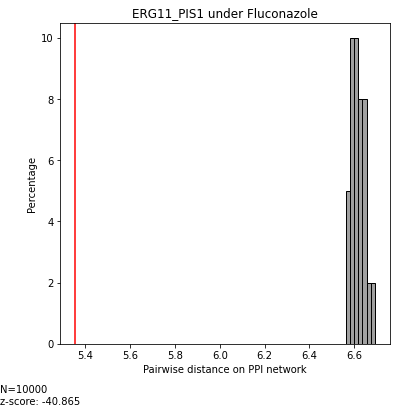

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|██████████| 10000/10000 [00:51<00:00, 195.75it/s]


-41.30296562895859


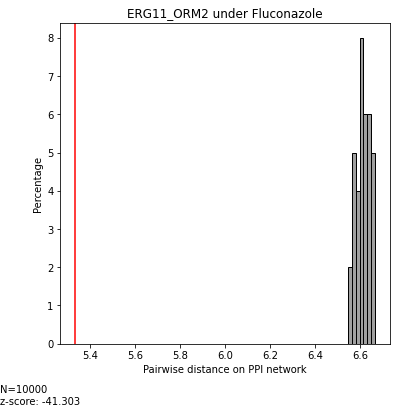

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|██████████| 10000/10000 [00:38<00:00, 257.02it/s]


-46.10376527873248


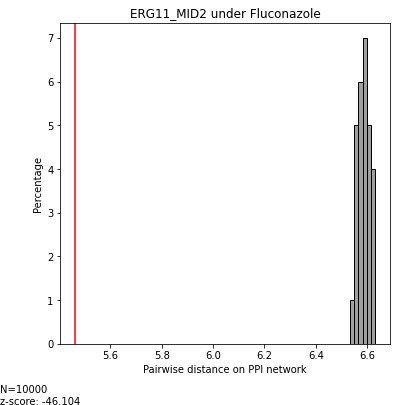

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|██████████| 10000/10000 [00:37<00:00, 266.46it/s]


-90.64090642376297


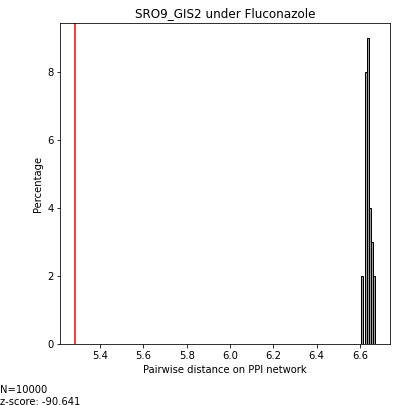

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|██████████| 10000/10000 [00:36<00:00, 276.81it/s]


-55.1139528527653


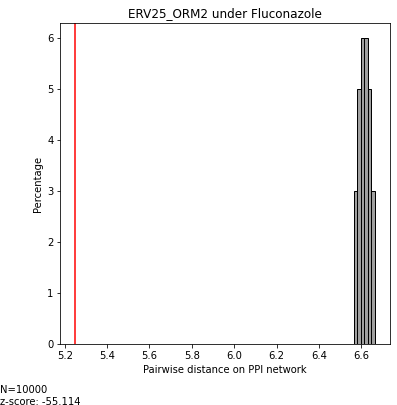

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|██████████| 10000/10000 [00:26<00:00, 372.47it/s]


-37.49175057752474


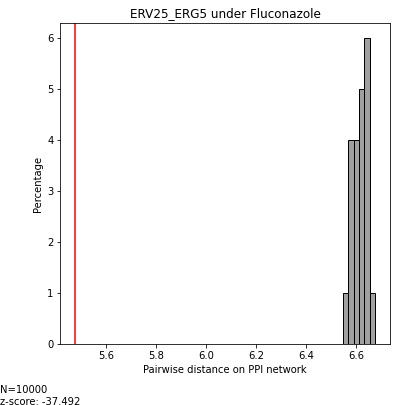

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|██████████| 10000/10000 [00:26<00:00, 375.88it/s]


-63.680168686961935


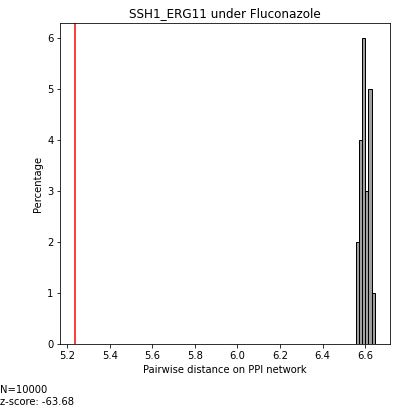

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|██████████| 7/7 [04:54<00:00, 42.02s/it]


In [337]:
pca_all_zscore = [] 

folder_path = '../piQTL/data/piQTLs/piQTL_without_MTX'

for PPI in tqdm(piQTLs_stats[piQTLs_stats['piQTLs'] >= 5]['PPI']): 
    for DRUG in ['Fluconazole'] : 
        CHR_bait =  PPI_list[PPI_list['PPI'] == PPI]['CHR_bait'].values[0] 
        CHR_prey = PPI_list[PPI_list['PPI'] == PPI]['CHR_prey'].values[0]

        MTX = pd.read_csv(os.path.join(folder_path,f'{PPI}_MTX_{DRUG}_avg_logratio_Fitness_minus_ref.csv'))
        MTX['SNP_ID'] = [ f'CHR{MTX["CHR"][idx]}_{MTX["SNP"][idx]}' for idx in MTX.index ]
        MTX['-log_pval'] = -np.log10(MTX['P'])
        pca_graph, attrs, piQTLs, noQTLs = get_network(G_PCA, PPI, 'MTX', DRUG, MTX, gene_loc)
        
        all_piQTLs = [] 
        all_nodes_for_random = []
        for piQTL in piQTLs : 
            all_piQTLs.append(piQTL)
            all_nodes_for_random.append(piQTL)
        for noQTL in noQTLs :
            all_nodes_for_random.append(noQTL)

        
        piQTLs_in_network = [ piQTL for piQTL in set(all_piQTLs) if piQTL in G_PCA.nodes() ]
        noQTLs_in_network = [ noQTL for noQTL in set(all_nodes_for_random) if noQTL in G_PCA.nodes() ]
        

        all_distance = [] 

        for i in range(len(piQTLs_in_network)):
            for j in range(i+1, len(piQTLs_in_network)):
                A = piQTLs_in_network[i]
                B = piQTLs_in_network[j]
                try : 
                    distance = len(nx.shortest_path(G_PCA, A, B))
                except: 
                    distance = 15
                all_distance.append(distance)

        SIM = 10000
        N = len(piQTLs_in_network)
        all_randoms = []
        all_randoms_ks = []
        CM = 1/2.54 # centimeters in inches
        f = plt.figure(figsize=(15*CM,15*CM))
        for S in tqdm(range(SIM)):
            all_distance_random = [] 
            random_nodes = random.choices(noQTLs_in_network, k=N)
            # print(random_nodes)
            
            for i in range(len(random_nodes)):
                for j in range(i+1, len(random_nodes)):
                    A = random_nodes[i]
                    B = random_nodes[j]
                    try : 
                        distance = len(nx.shortest_path(G_PCA, A, B))
                    except: 
                        distance = 15

                    all_distance_random.append(distance)
            all_randoms.append(all_distance_random)
        # [ val for vals in pd.DataFrame(np.array(all_randoms)).values for val in vals ]
        # sns.kdeplot([ val for vals in pd.DataFrame(np.array(all_randoms)).values for val in vals], color='black')
        sns.histplot(pd.DataFrame(np.array(all_randoms)).mean(), color='grey')
        plt.axvline(x=np.mean(all_distance), color='red')
        plt.ylabel('Percentage')
        plt.xlabel('Pairwise distance on PPI network')
        plt.title(f'{PPI} under Fluconazole')

        # mu = np.mean(pd.DataFrame(np.array(all_randoms)).mean())
        # std = np.std(pd.DataFrame(np.array(all_randoms)).mean())
        # z = (np.mean(all_distance) - mu) / std 
        # print(len(piQTLs_in_network))
        # print(all_distance)
        # print(np.mean(all_distance))
        # print('mu: ', mu, 'std: ', std)
        # print(z)

        moy = np.mean(all_distance)
        mu = np.mean(pd.DataFrame(np.array(all_randoms)).mean())
        std = np.std(pd.DataFrame(np.array(all_randoms)).mean())
        z = (moy - mu) / std
        print(z)

        plt.annotate(f'N={SIM}\nz-score: {np.round(z, 3)}', xy=[0, 1], xycoords="figure points")
        plt.show()
        try: 
            ks_stat, ks_pval = (stats.kstest(all_distance, pd.DataFrame(np.array(all_randoms)).mean().tolist(), alternative='greater'))
        except: 
            ks_pval = 1
        
        f.savefig(f'../piQTL/results/09_PPI_network/PPI_network_shortest_paths_{PPI}.eps', dpi=300)
        pca_all_zscore.append([PPI, len(piQTLs_in_network), z])

In [313]:
pca_pvals = pd.DataFrame(pca_all_zscore, columns=['PPI', 'n_piQTLs','PCA_zscore']) # .to_csv('./PPI_network_distance_zcore_10000.csv', index=False)

In [314]:
pca_pvals

,PPI,n_piQTLs,PCA_zscore
0,ERG11_PIS1,10,-17.578491
1,ERG11_ORM2,9,-17.107546
2,ERG11_MID2,8,-14.162770
3,SRO9_GIS2,8,-12.798875
4,ERV25_ORM2,8,-10.910813
5,ERV25_ERG5,7,-14.718827
6,SSH1_ERG11,7,-21.467033


100%|██████████| 1000/1000 [00:25<00:00, 39.01it/s]


34.472224967200994


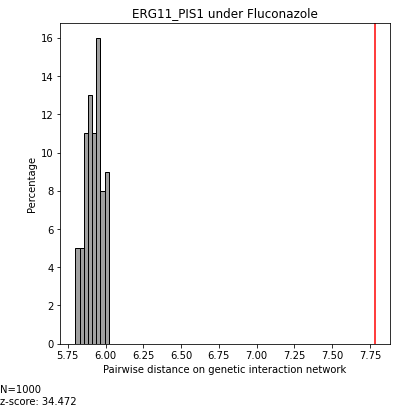

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|██████████| 1000/1000 [00:24<00:00, 40.45it/s]


9.047939089423023


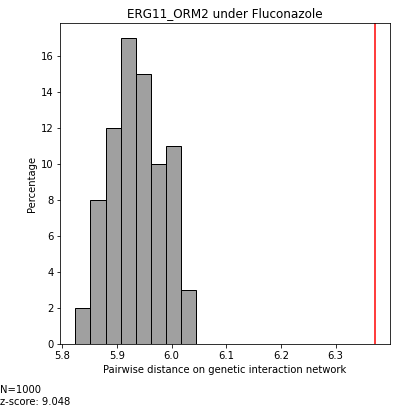

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|██████████| 1000/1000 [00:21<00:00, 46.96it/s]


34.524502695278564


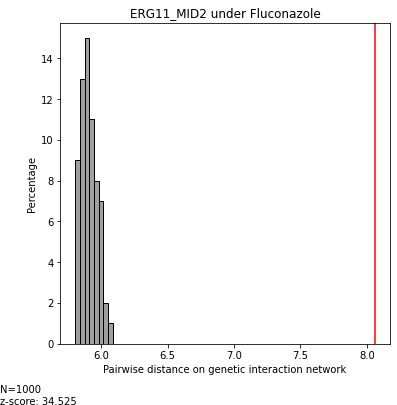

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|██████████| 1000/1000 [00:08<00:00, 112.98it/s]


52.538460655179655


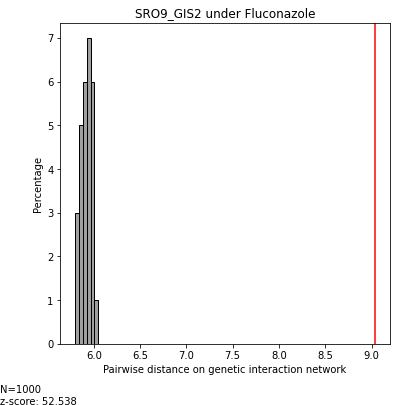

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|██████████| 1000/1000 [00:14<00:00, 68.02it/s]


30.13173745569257


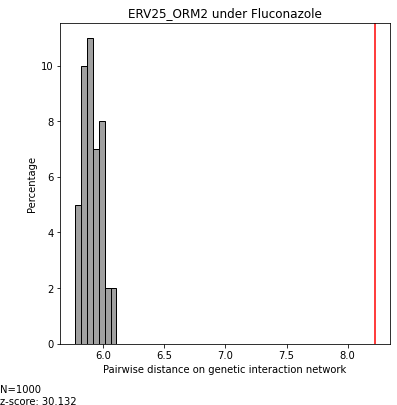

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|██████████| 1000/1000 [00:04<00:00, 201.37it/s]


77.48553747638091


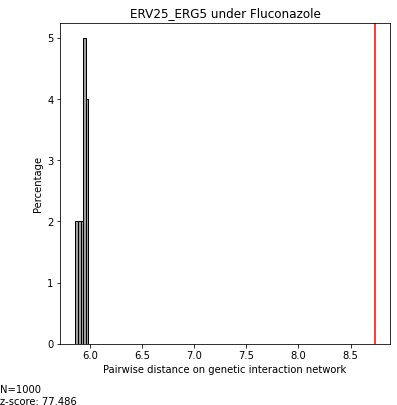

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|██████████| 1000/1000 [00:06<00:00, 148.18it/s]


27.05539412421127


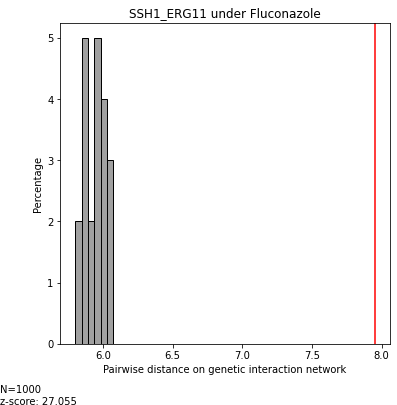

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|██████████| 7/7 [01:58<00:00, 16.91s/it]


In [315]:
cellmap_all_zscore = [] 

for PPI in tqdm(piQTLs_stats[piQTLs_stats['piQTLs'] >= 5]['PPI']): 
    for DRUG in ['Fluconazole'] : 
        CHR_bait =  PPI_list[PPI_list['PPI'] == PPI]['CHR_bait'].values[0] 
        CHR_prey = PPI_list[PPI_list['PPI'] == PPI]['CHR_prey'].values[0]

        MTX = pd.read_csv(os.path.join(folder_path,f'{PPI}_MTX_{DRUG}_avg_logratio_Fitness_minus_ref.csv'))
        MTX['SNP_ID'] = [ f'CHR{MTX["CHR"][idx]}_{MTX["SNP"][idx]}' for idx in MTX.index ]
        MTX['-log_pval'] = -np.log10(MTX['P'])
        pca_graph, attrs, piQTLs, noQTLs = get_network(G_cellMap, PPI, 'MTX', DRUG, MTX, gene_loc)
        
        all_piQTLs = [] 
        all_nodes_for_random = []
        for piQTL in piQTLs : 
            all_piQTLs.append(piQTL)
            all_nodes_for_random.append(piQTL)
        for noQTL in noQTLs :
            all_nodes_for_random.append(noQTL)
            
        piQTLs_in_network = [ piQTL for piQTL in set(all_piQTLs) if piQTL in G_cellMap.nodes() ]
        noQTLs_in_network = [ noQTL for noQTL in set(all_nodes_for_random) if noQTL in G_cellMap.nodes() ]

        CM = 1/2.54 # centimeters in inches
        f = plt.figure(figsize=(15*CM,15*CM))
        all_distance = [] 
        for i in range(len(piQTLs_in_network)):
            for j in range(i+1, len(piQTLs_in_network)):
                A = piQTLs_in_network[i]
                B = piQTLs_in_network[j]
                try : 
                    distance = len(nx.shortest_path(G_cellMap, A, B))
                except: 
                    distance = 15
                all_distance.append(distance)

        SIM = 1000
        N = len(piQTLs_in_network)

        all_randoms = []
        for S in tqdm(range(SIM)):
            all_distance_random = [] 
            random_nodes = random.choices(noQTLs_in_network, k=N)
            # print(random_nodes)
            for i in range(len(random_nodes)):
                for j in range(i+1, len(random_nodes)):
                    A = random_nodes[i]
                    B = random_nodes[j]
                    try : 
                        distance = len(nx.shortest_path(G_cellMap, A, B))
                    except: 
                        distance = 15

                    all_distance_random.append(distance)
            # sns.histplot(all_distance_random, color='grey')
            all_randoms.append(all_distance_random)


        sns.histplot(pd.DataFrame(np.array(all_randoms)).mean(), color='grey')
        plt.axvline(x=np.mean(all_distance), color='red')
        plt.ylabel('Percentage')
        plt.xlabel('Pairwise distance on genetic interaction network')
        plt.title(f'{PPI} under Fluconazole')

        moy = np.mean(all_distance)
        mu = np.mean(pd.DataFrame(np.array(all_randoms)).mean())
        std = np.std(pd.DataFrame(np.array(all_randoms)).mean())
        z = (moy - mu) / std
        print(z)
        plt.annotate(f'N={SIM}\nz-score: {np.round(z, 3)}', xy=[0, 1], xycoords="figure points")
        plt.show()
        try: 
            ks_stat, ks_pval = (stats.kstest(all_distance, pd.DataFrame(np.array(all_randoms)).mean().tolist(), alternative='greater'))
        except: 
            ks_pval = 1
        cellmap_all_zscore.append([PPI, len(piQTLs_in_network), z])
        f.savefig(f'../piQTL/results/09_PPI_network/GE_network_shortest_paths_{PPI}.eps', dpi=300)
        

In [316]:
cellmap_pvals = pd.DataFrame(cellmap_all_zscore, columns=['PPI', 'n_piQTLs','Cellmap_zscore']) # .to_csv('./GE_network_distance_zcore_10000.csv', index=False)

In [317]:
cellmap_pvals

,PPI,n_piQTLs,Cellmap_zscore
0,ERG11_PIS1,13,34.472225
1,ERG11_ORM2,13,9.047939
2,ERG11_MID2,12,34.524503
3,SRO9_GIS2,8,52.538461
4,ERV25_ORM2,10,30.131737
5,ERV25_ERG5,6,77.485537
6,SSH1_ERG11,7,27.055394


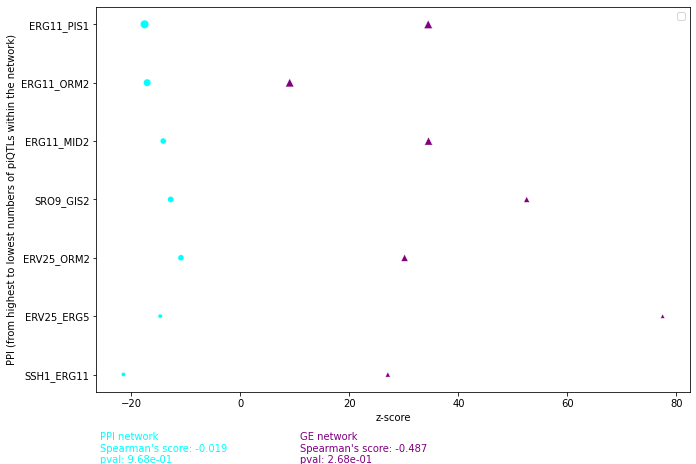

In [318]:
f = plt.figure(figsize=(27*CM, 18*CM))

sns.scatterplot(y=pca_pvals['PPI'], x=pca_pvals['PCA_zscore'], size=pca_pvals['n_piQTLs'], color='cyan', marker='o')
plt.ylabel('PPI (from highest to lowest numbers of piQTLs within the network)')
plt.xlabel('z-score')
sp_corr1, pval1 = stats.spearmanr(pca_pvals['n_piQTLs'], pca_pvals['PCA_zscore'])
plt.annotate(f"PPI network\nSpearman's score: {round(sp_corr1,3)}\npval: {'{:.2e}'.format(pval1)}", xy=[100, 1], xycoords="figure points", color='cyan')

sns.scatterplot(y=cellmap_pvals['PPI'], x=cellmap_pvals['Cellmap_zscore'], size=cellmap_pvals['n_piQTLs'], color='purple', marker='^')

# plt.legend(['PPI network', 'GE network'])
sp_corr2, pval2 = stats.spearmanr(cellmap_pvals['n_piQTLs'], cellmap_pvals['Cellmap_zscore'])
plt.annotate(f"GE network\nSpearman's score: {round(sp_corr2,3)}\npval: {'{:.2e}'.format(pval2)}", xy=[300, 1], xycoords="figure points", color='purple')

plt.legend([])
# f.savefig('../piQTL/results/09_PPI_network/PPI_vs_GE_network_analysis_shortest_path_piQTLs.eps', dpi=300)

In [319]:
pca = pd.DataFrame(pca_all_zscore, columns=['PPI', 'n_piQTLs','z-score'])
pca['network_type'] = 'PPI'
cellmap = pd.DataFrame(cellmap_all_zscore, columns=['PPI', 'n_piQTLs','z-score'])
cellmap['network_type'] = 'GI'

merged_zscores = pd.concat([pca, cellmap])

Text(0, 0.5, 'z-score')

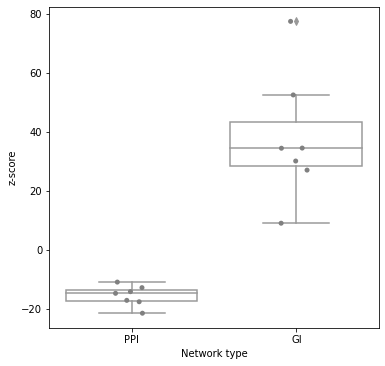

In [336]:
CM = 1/2.54 # centimeters in inches
f = plt.figure(figsize=(15*CM,15*CM))
sns.boxplot(x=merged_zscores['network_type'], y=merged_zscores['z-score'], color='white')
sns.stripplot(x=merged_zscores['network_type'], y=merged_zscores['z-score'], palette=['cyan','grey'])
plt.xlabel('Network type')
plt.ylabel('z-score') 
# f.savefig('../piQTL/results/09_PPI_network/PPI_vs_GE_network_analysis_shortest_path_boxplot.eps', dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


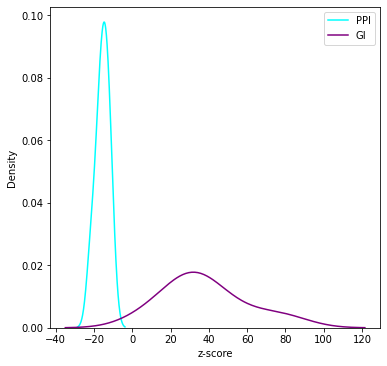

In [334]:
CM = 1/2.54 # centimeters in inches
f = plt.figure(figsize=(15*CM,15*CM))
sns.kdeplot(x=pca_pvals['PCA_zscore'], color='cyan')
sns.kdeplot(x=cellmap_pvals['Cellmap_zscore'], color='purple')
plt.xlabel('z-score')
plt.legend(['PPI', 'GI'])
f.savefig('../piQTL/results/09_PPI_network/PPI_vs_GE_network_analysis_shortest_path_kdeplot.eps', dpi=300)

In [ ]:
piQTLs_in_network = [ piQTL for piQTL in set(all_piQTLs) if piQTL in G_PCA.nodes() ]
noQTLs_in_network = [ noQTL for noQTL in set(all_nodes_for_random) if noQTL in G_PCA.nodes() ]

all_distance = [] 
for i in range(len(piQTLs_in_network)):
    for j in range(i+1, len(piQTLs_in_network)):
        A = piQTLs_in_network[i]
        B = piQTLs_in_network[j]
        try : 
            distance = len(nx.shortest_path(G_PCA, A, B))
        except: 
            distance = 15
        all_distance.append(distance)

SIM = 100
N = len(piQTLs_in_network)
all_randoms = []

f = plt.figure(figsize=(15*CM,15*CM))
for S in tqdm(range(SIM)):
    all_distance_random = [] 
    random_nodes = random.choices(noQTLs_in_network, k=N)
    # print(random_nodes)
    
    for i in range(len(random_nodes)):
        for j in range(i+1, len(random_nodes)):
            A = random_nodes[i]
            B = random_nodes[j]
            try : 
                distance = len(nx.shortest_path(G_PCA, A, B))
            except: 
                distance = 15

            all_distance_random.append(distance)
    # sns.histplot(all_distance_random, color='grey')
    all_randoms.append(all_distance_random)

# sns.histplot(all_distance, color='red')

sns.histplot(pd.DataFrame(np.array(all_randoms)).mean(), stat='percent', color='grey')
plt.axvline(x=np.mean(all_distance), color='red')
plt.ylabel('Percentage')
plt.xlabel('Pairwise distance on PPI network')

stat, pval = stats.kstest(pd.DataFrame(np.array(all_randoms)).mean(), all_distance)

mu = np.mean(pd.DataFrame(np.array(all_randoms)).mean())
std = np.std(pd.DataFrame(np.array(all_randoms)).mean())
z = (np.mean(all_distance) - mu) / std 
print(z)
# plt.annotate(f"KS statistic: {round(stat,3)}\npval: {'{:.2e}'.format(pval)}", xy=[0, 1], xycoords="figure points")
plt.title('Fluconazole')
# f.savefig('../piQTL/results/09_PPI_network/PPI_network_shortest_paths.eps', dpi=300)

In [ ]:
piQTLs_in_network = [ piQTL for piQTL in set(all_piQTLs) if piQTL in G_cellMap.nodes() ]
noQTLs_in_network = [ noQTL for noQTL in set(all_nodes_for_random) if noQTL in G_cellMap.nodes() ]

CM = 1/2.54 # centimeters in inches
f = plt.figure(figsize=(15*CM,15*CM))
all_distance = [] 
for i in range(len(piQTLs_in_network)):
    for j in range(i+1, len(piQTLs_in_network)):
        A = piQTLs_in_network[i]
        B = piQTLs_in_network[j]
        try : 
            distance = len(nx.shortest_path(G_cellMap, A, B))
        except: 
            distance = 15
        all_distance.append(distance)

SIM = 100
N = len(piQTLs_in_network)

all_randoms = []
for S in tqdm(range(SIM)):
    all_distance_random = [] 
    random_nodes = random.choices(noQTLs_in_network, k=N)
    # print(random_nodes)
    for i in range(len(random_nodes)):
        for j in range(i+1, len(random_nodes)):
            A = random_nodes[i]
            B = random_nodes[j]
            try : 
                distance = len(nx.shortest_path(G_cellMap, A, B))
            except: 
                distance = 15

            all_distance_random.append(distance)
    # sns.histplot(all_distance_random, color='grey')
    all_randoms.append(all_distance_random)


sns.histplot(pd.DataFrame(np.array(all_randoms)).mean(), stat='percent', color='grey')
plt.axvline(x=np.mean(all_distance), color='red')
plt.ylabel('Percentage')
plt.xlabel('Pairwise distance on genetic interaction network')

stat, pval = stats.kstest(pd.DataFrame(np.array(all_randoms)).mean(), all_distance)
plt.annotate(f"KS statistic: {round(stat,3)}\npval: {'{:.2e}'.format(pval)}", xy=[0, 1], xycoords="figure points")
plt.title('Fluconazole')
f.savefig('../piQTL/results/09_PPI_network/GE_network_shortest_paths.eps', dpi=300)

In [ ]:
folder_path = '../piQTL/data/QTL'
for PPI in tqdm(['ERG11_ORM2']): 
    for DRUG in ['Fluconazole'] : 
        CHR_bait =  PPI_list[PPI_list['PPI'] == PPI]['CHR_bait'].values[0] 
        CHR_prey = PPI_list[PPI_list['PPI'] == PPI]['CHR_prey'].values[0]

        MTX = pd.read_csv(os.path.join(folder_path,f'{PPI}_MTX_{DRUG}_avg_logratio_Fitness_minus_ref.csv'))
        MTX['SNP_ID'] = [ f'CHR{MTX["CHR"][idx]}_{MTX["SNP"][idx]}' for idx in MTX.index ]
        MTX['-log_pval'] = -np.log10(MTX['P'])
        MTX[f'{PPI}_MTX_{DRUG}'] = [ set_correlation_score(idx, MTX) for idx in MTX.index ]
        f_graph, attrs, PPI_left, PPI_right, piQTLs  = display_network_v3(G_cellMap, PPI, 'MTX', DRUG, MTX, gene_loc)
        

layout = nx.nx_agraph.graphviz_layout(f_graph, prog="fdp")

f = plt.figure(figsize=(15,10))

for node in f_graph.nodes() :
    if (node == PPI_left) or (node == PPI_right):
        nx.draw_networkx_nodes(f_graph, pos=layout, nodelist=[node], node_color=attrs[node]['color'], node_size=attrs[node]['lod'], label=attrs[node]['label'], node_shape='s')     
    elif node in piQTLs:
        nx.draw_networkx_nodes(f_graph, pos=layout, nodelist=[node], node_color=attrs[node]['color'], node_size=attrs[node]['lod'], label=attrs[node]['label'])
    else :
        nx.draw_networkx_nodes(f_graph, pos=layout, nodelist=[node], node_color=attrs[node]['color'], node_size=attrs[node]['lod'])
   
for edge in f_graph.edges(data="weight"):
    if (PPI_left in edge) and (PPI_right in edge):
        nx.draw_networkx_edges(f_graph, pos=layout, edgelist=[edge], edge_color='red')
    else : 
        nx.draw_networkx_edges(f_graph, pos=layout, edgelist=[edge], edge_color='grey')

nx.draw_networkx_labels(f_graph, pos=layout, font_size=10, horizontalalignment='right', labels={n:attrs[n]['label'] for n in attrs.keys() if (n in [PPI_left, PPI_right]) or (n in piQTLs)})

plt.title(f'{PPI} under Fluconazole (CellMap)')
plt.show()
f.savefig(f'./{PPI}_Fluconazole_CellMap.pdf', dpi=300)

#### One example (PCA)

In [ ]:
folder_path = './data/QTLs'
for PPI in tqdm(['ERG11_ORM2']): 
    for DRUG in ['Fluconazole'] : 
        CHR_bait =  PPI_list[PPI_list['PPI'] == PPI]['CHR_bait'].values[0] 
        CHR_prey = PPI_list[PPI_list['PPI'] == PPI]['CHR_prey'].values[0]

        MTX = pd.read_csv(os.path.join(folder_path,f'{PPI}_MTX_{DRUG}_avg_logratio_Fitness_substract_ref.csv'))
        MTX = MTX.rename(columns={f'{PPI}_MTX_{DRUG}_avg_logratio_Fitness_substract_ref.GLM':'p-value'})
        MTX['SNP_ID'] = [ f'CHR{MTX["Chr"][idx]}_{MTX["Pos"][idx]}' for idx in MTX.index ]
        # noMTX = pd.read_csv(os.path.join(folder_path,f'{PPI}_noMTX_{DRUG}_avg_logratio_Fitness_substract_ref.csv'))
        # noMTX = noMTX.rename(columns={f'{PPI}_noMTX_{DRUG}_avg_logratio_Fitness_substract_ref.GLM':'p-value'})
        # noMTX['SNP_ID'] = [ f'CHR{noMTX["Chr"][idx]}_{noMTX["Pos"][idx]}' for idx in noMTX.index ]
        
        MTX['-log_pval'] = -np.log10(MTX['p-value'])
        MTX[f'{PPI}_MTX_{DRUG}'] = [ set_correlation_score(idx, MTX) for idx in MTX.index ]
        f_graph, attrs, PPI_left, PPI_right, piQTLs, MTXs  = display_network_v2(G_PCA, PPI, 'MTX', DRUG, MTX, gene_loc)
        
        # noMTX['-log_pval'] = -np.log10(noMTX['p-value'])
        # noMTX[f'{PPI}_noMTX_{DRUG}'] = [ set_correlation_score(idx, noMTX) for idx in MTX.index ]
        # g_graph, g_color_map = display_network(G_cellMap, PPI, 'noMTX', DRUG, noMTX, gene_loc)

layout = nx.nx_agraph.graphviz_layout(f_graph, prog="fdp")

f = plt.figure(figsize=(15,10))

for node in f_graph.nodes() :
    if (node == PPI_left) or (node == PPI_right):
        nx.draw_networkx_nodes(f_graph, pos=layout, nodelist=[node], node_color=attrs[node]['color'], node_size=attrs[node]['effect_size'], label=attrs[node]['label'], node_shape='s')     
    elif node in piQTLs:
        nx.draw_networkx_nodes(f_graph, pos=layout, nodelist=[node], node_color=attrs[node]['color'], node_size=attrs[node]['effect_size'], label=attrs[node]['label'])
    elif node in MTXs :
        nx.draw_networkx_nodes(f_graph, pos=layout, nodelist=[node], node_color=attrs[node]['color'], node_size=attrs[node]['effect_size'], label=attrs[node]['label'], node_shape='^')
    else :
        nx.draw_networkx_nodes(f_graph, pos=layout, nodelist=[node], node_color=attrs[node]['color'], node_size=attrs[node]['effect_size'])
   
for edge in f_graph.edges(data="weight"):
    if (PPI_left in edge) and (PPI_right in edge):
        nx.draw_networkx_edges(f_graph, pos=layout, edgelist=[edge], edge_color='red')
    else : 
        nx.draw_networkx_edges(f_graph, pos=layout, edgelist=[edge], edge_color='grey')

nx.draw_networkx_labels(f_graph, pos=layout, font_size=8, horizontalalignment='right', labels={n:attrs[n]['label'] for n in attrs.keys() if (n in [PPI_left, PPI_right]) or (n in piQTLs) or (n in MTXs)})

plt.title('ERG11:PIS1 under Fluconazole (PCA)')
plt.show()

# f.savefig('./GTR1_SLM4_Fluconazole_CellMap.pdf', dpi=300)

#### One example (CellMap)

In [ ]:
folder_path = './data/QTLs'
cellmap_corr_table = []
for PPI in tqdm(['ERG11_ORM2']): 
    for DRUG in ['Fluconazole'] : 

        CHR_bait =  PPI_list[PPI_list['PPI'] == PPI]['CHR_bait'].values[0] 
        CHR_prey = PPI_list[PPI_list['PPI'] == PPI]['CHR_prey'].values[0]

        MTX = pd.read_csv(os.path.join(folder_path,f'{PPI}_MTX_{DRUG}_avg_logratio_Fitness_substract_ref.csv'))
        MTX = MTX.rename(columns={f'{PPI}_MTX_{DRUG}_avg_logratio_Fitness_substract_ref.GLM':'p-value'})
        MTX['SNP_ID'] = [ f'CHR{MTX["Chr"][idx]}_{MTX["Pos"][idx]}' for idx in MTX.index ]
        # noMTX = pd.read_csv(os.path.join(folder_path,f'{PPI}_noMTX_{DRUG}_avg_logratio_Fitness_substract_ref.csv'))
        # noMTX = noMTX.rename(columns={f'{PPI}_noMTX_{DRUG}_avg_logratio_Fitness_substract_ref.GLM':'p-value'})
        # noMTX['SNP_ID'] = [ f'CHR{noMTX["Chr"][idx]}_{noMTX["Pos"][idx]}' for idx in noMTX.index ]
        
        MTX['-log_pval'] = -np.log10(MTX['p-value'])
        MTX[f'{PPI}_MTX_{DRUG}'] = [ set_correlation_score(idx, MTX) for idx in MTX.index ]
        f_graph, attrs, PPI_left, PPI_right, piQTLs, MTXs  = display_network_v2(G_cellMap, PPI, 'MTX', DRUG, MTX, gene_loc)

layout = nx.nx_agraph.graphviz_layout(f_graph, prog="fdp")

f = plt.figure(figsize=(15,10))
sns.set_context("talk", font_scale=1.5)
sns.set_style("ticks") 
sns.despine(offset=20)

for node in f_graph.nodes() :
    if node in piQTLs:
        nx.draw_networkx_nodes(f_graph, pos=layout, nodelist=[node], node_color=attrs[node]['color'], node_size=attrs[node]['effect_size'], label=attrs[node]['label'])
    elif node in MTXs :
        nx.draw_networkx_nodes(f_graph, pos=layout, nodelist=[node], node_color=attrs[node]['color'], node_size=attrs[node]['effect_size'], label=attrs[node]['label'], node_shape='^')
    else :
        nx.draw_networkx_nodes(f_graph, pos=layout, nodelist=[node], node_color=attrs[node]['color'], node_size=attrs[node]['effect_size'])
   
for edge in f_graph.edges(data="weight"):
    if (PPI_left in edge) and (PPI_right in edge):
        nx.draw_networkx_edges(f_graph, pos=layout, edgelist=[edge], edge_color='red')
    else : 
        nx.draw_networkx_edges(f_graph, pos=layout, edgelist=[edge], edge_color='grey')

nx.draw_networkx_labels(f_graph, pos=layout, font_size=14, horizontalalignment='right', font_color='red', labels={n:attrs[n]['label'] for n in attrs.keys() if (n in [PPI_left, PPI_right])})
nx.draw_networkx_labels(f_graph, pos=layout, font_size=14, horizontalalignment='right', labels={n:attrs[n]['label'] for n in attrs.keys() if (n in piQTLs) or (n in MTXs)})

plt.title('ERG11:PIS1 under Fluconazole (CellMap)')
plt.show()

# f.savefig('./GTR1_SLM4_Fluconazole_CellMap.pdf', dpi=300)

____

#### All PPIs

In [ ]:
folder_path = './data/QTLs'
string_corr_table = []
for PPI in tqdm(PPI_list['PPI'][:-1]): 
    for DRUG in ['5.FC', 'Fluconazole', 'Metformin', 'Trifluoperazine', 'noDrug'] : 
        CHR_bait =  PPI_list[PPI_list['PPI'] == PPI]['CHR_bait'].values[0] 
        CHR_prey = PPI_list[PPI_list['PPI'] == PPI]['CHR_prey'].values[0]

        MTX = pd.read_csv(os.path.join(folder_path,f'{PPI}_MTX_{DRUG}_avg_logratio_Fitness_substract_ref.csv'))
        MTX = MTX.rename(columns={f'{PPI}_MTX_{DRUG}_avg_logratio_Fitness_substract_ref.GLM':'p-value'})
        MTX['SNP_ID'] = [ f'CHR{MTX["Chr"][idx]}_{MTX["Pos"][idx]}' for idx in MTX.index ]
        noMTX = pd.read_csv(os.path.join(folder_path,f'{PPI}_noMTX_{DRUG}_avg_logratio_Fitness_substract_ref.csv'))
        noMTX = noMTX.rename(columns={f'{PPI}_noMTX_{DRUG}_avg_logratio_Fitness_substract_ref.GLM':'p-value'})
        noMTX['SNP_ID'] = [ f'CHR{noMTX["Chr"][idx]}_{noMTX["Pos"][idx]}' for idx in noMTX.index ]
        
        MTX['-log_pval'] = -np.log10(MTX['p-value'])
        MTX[f'{PPI}_MTX_{DRUG}'] = [ set_correlation_score(idx, MTX) for idx in MTX.index ]
        f_graph, attrs, PPI_left, PPI_right, piQTLs, MTXs  = display_network_v2(G_string, PPI, 'MTX', DRUG, MTX, gene_loc)
        
        # noMTX['-log_pval'] = -np.log10(noMTX['p-value'])
        # noMTX[f'{PPI}_noMTX_{DRUG}'] = [ set_correlation_score(idx, noMTX) for idx in MTX.index ]
        # g_graph, g_color_map = display_network(G_cellMap, PPI, 'noMTX', DRUG, noMTX, gene_loc)

        # table = pd.DataFrame.from_dict(dict(f_graph.nodes(data=True)), orient='index')
        # sns.scatterplot(data=table[table['effect_size'] != 0], x='effect_size', y='degree')
        # corr, pval = stats.spearmanr(table[table['effect_size'] != 0]['effect_size'], table[table['effect_size'] != 0]['degree'])

        # string_corr_table.append([f'{PPI}_MTX_{DRUG}', corr, pval])


### Node degree versus effect size

In [ ]:
AUC_table = pd.read_csv('../piQTL_project/piQTL_story/QTL_mapping/data/empirical_auc.csv')
AUC_table['mtx'] = AUC_table['mtx'].replace(0, 'noMTX')
AUC_table['mtx'] = AUC_table['mtx'].replace(10, 'MTX')
AUC_table['drug'] = AUC_table['drug'].replace('NoDrug', 'noDrug').replace('5FC','5.FC')
AUC_table['Condition'] = [ f'{AUC_table["ppi"][idx].replace(":","_")}_{AUC_table["mtx"][idx]}_{AUC_table["drug"][idx]}' for idx in AUC_table.index ]

In [ ]:
cellmap_vs_auc = cellmap_df.merge(AUC_table, on='Condition')

In [ ]:
sns.displot(cellmap_vs_auc['correlation'])

In [ ]:
cellmap_vs_auc.sort_values('correlation').head(20)

In [ ]:
cellmap_vs_auc = cellmap_vs_auc.sort_values('auc_average', ascending=False)
sns.scatterplot(x=cellmap_vs_auc['auc_average'], y=cellmap_vs_auc['correlation'])